Simulating an Airplane in 2d
state x is [x_pos, z_pos, velocity, and upsilon (flight path angle, angle between earth frame and velocity frame )] ^T
input is [Thrust T, alpha (angel of attack, angel between body frame and velocity frame)]^T

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import fsolve
import yaml
import control
%load_ext autoreload
%autoreload 2

In [2]:
def find_steady_straight_flight(earth_to_wind_angle, V_magnitude):

    with open("aerosonde_parameters.yaml", 'r') as file:
            params = yaml.safe_load(file)
    g = params['environmental']['gravity']
    mass = params['physical']['mass']   

    def equations(vars):
        u, w, theta, alpha, elevator = vars
        
        C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
                params['long_coef']['C_L_elevator'] * elevator
            
        C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
            params['long_coef']['C_D_elevator'] * elevator
    
        L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
        D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D

        C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha + \
                params['long_coef']['C_M_moment_elevator'] * elevator
        w_dot = g*np.cos(theta) - D*np.sin(alpha)/mass - L*np.cos(alpha)/mass
        alpha_zero = alpha - np.arctan2(w,u)
        V_magnitude_zero = V_magnitude - np.sqrt(u**2 + w**2)
        earth_to_wind_angle_zero = earth_to_wind_angle - (theta-alpha)

        return [C_M_moment, w_dot, alpha_zero, V_magnitude_zero, earth_to_wind_angle_zero]
    
    u, w, theta, alpha, elevator = fsolve(equations, (1, 1, earth_to_wind_angle, 0, 0))

    # now solve for T
    V_magnitude = np.sqrt(u**2 + w**2)
    C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
            params['long_coef']['C_L_elevator'] * elevator
            
    C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
        params['long_coef']['C_D_elevator'] * elevator

    L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
    D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D

    T = g*np.sin(theta)*mass + D*np.cos(alpha) -L*np.sin(alpha)
            
    return(u, w, theta, alpha, elevator, T)

In [4]:
def find_steady_turn(psi_dot):
    with open("aerosonde_parameters.yaml", 'r') as file:
            params = yaml.safe_load(file)
    g = params['environmental']['gravity']
    mass = params['physical']['mass'] 
    Ixx = params['physical']['Ixx']
    Iyy = params['physical']['Iyy']
    Izz = params['physical']['Izz']
    Ixz = params['physical']['Ixz']
    
    alpha = 0
    beta = 0
    theta = 0
    p = 0
    v = 0
    w = 0

    def equations(vars):
        phi, u, r, q, elevator, aileron, rudder = vars
        V_magnitude = u

        C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
            params['long_coef']['C_L_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_L_elevator'] * elevator
        
        C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
            params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_D_elevator'] * elevator
        
        C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha + \
            params['long_coef']['C_M_moment_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_M_moment_elevator'] * elevator
        
    
        L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
        D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D
        M_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
                    * params['physical']['c_wing_chord'] * C_M_moment
        

        C_y = params['lat_coef']['C_y_0'] + params['lat_coef']['C_y_beta'] * beta + \
            params['lat_coef']['C_y_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_y_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_y_aileron'] * aileron + params['lat_coef']['C_y_rudder'] * rudder
        
        C_L_moment = params['lat_coef']['C_L_moment_0'] + params['lat_coef']['C_L_moment_beta'] * beta + \
            params['lat_coef']['C_L_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_L_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_L_moment_aileron'] * aileron + params['lat_coef']['C_L_moment_rudder'] * rudder
        
        C_N_moment = params['lat_coef']['C_N_moment_0'] + params['lat_coef']['C_N_moment_beta'] * beta + \
            params['lat_coef']['C_N_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_N_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_N_moment_aileron'] * aileron + params['lat_coef']['C_N_moment_rudder'] * rudder

        F_y = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_y
        L_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] \
                    * params['physical']['b_wing_span'] * C_L_moment
        N_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
                    * params['physical']['b_wing_span'] * C_N_moment
        
        # 7 equations
        phi_dot = q*np.cos(phi) - r*np.sin(phi)
        psi_dot_zero = psi_dot - (q*np.sin(phi)+r*np.cos(phi))
        v_dot = g*np.cos(theta)*np.sin(phi) - D*np.sin(beta)/mass + F_y/mass -r*u+p*w
        w_dot = g*np.cos(theta)*np.cos(phi) - D*np.sin(alpha)*np.cos(beta)/mass - L*np.cos(alpha)/mass -p*v+q*u
        p_dot = ( -q*r*(Izz-Iyy) + N_moment*Ixz/Izz - p*q*Ixz*(Iyy-Ixx)/Izz - q*r*Ixz*Ixz/Izz +p*q*Ixz + L_moment)\
                                / (Ixx - Ixz*Ixz/Izz)
        
        q_dot = ( M_moment + p*r*(Izz-Ixx)-(p**2 - r**2)*Ixz ) / Iyy

        r_dot = ( -p*q*(Iyy-Ixx) - q*r*Ixz + L_moment*Ixz/Ixx - q*r*Ixz*(Izz-Iyy)/Ixx + p*q*Ixz*Ixz/Ixx + N_moment)\
                                / (Izz - Ixz*Ixz/Ixx)
        
        
        return[phi_dot, psi_dot_zero, v_dot, w_dot, p_dot, q_dot, r_dot]

    
    phi, u, r, q, elevator, aileron, rudder = fsolve(equations, (np.pi/4, 100, 0, 0, 0, 0, 0), maxfev=70000)

    # now solve for T    
    V_magnitude = u
    C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
        params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
        params['long_coef']['C_D_elevator'] * elevator

    D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D     

    T = D

    return phi, u, r, q, T, elevator, aileron, rudder

    

In [5]:
def find_steady_turn_radius(radius):
    with open("aerosonde_parameters.yaml", 'r') as file:
            params = yaml.safe_load(file)
    g = params['environmental']['gravity']
    mass = params['physical']['mass'] 
    Ixx = params['physical']['Ixx']
    Iyy = params['physical']['Iyy']
    Izz = params['physical']['Izz']
    Ixz = params['physical']['Ixz']
    
    alpha = 0
    beta = 0
    theta = 0
    p = 0
    v = 0
    w = 0

    def equations(vars):
        phi, psi_dot, u, r, q, elevator, aileron, rudder = vars
        V_magnitude = u

        C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
            params['long_coef']['C_L_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_L_elevator'] * elevator
        
        C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
            params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_D_elevator'] * elevator
        
        C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha + \
            params['long_coef']['C_M_moment_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_M_moment_elevator'] * elevator
        
    
        L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
        D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D
        M_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
                    * params['physical']['c_wing_chord'] * C_M_moment
        

        C_y = params['lat_coef']['C_y_0'] + params['lat_coef']['C_y_beta'] * beta + \
            params['lat_coef']['C_y_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_y_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_y_aileron'] * aileron + params['lat_coef']['C_y_rudder'] * rudder
        
        C_L_moment = params['lat_coef']['C_L_moment_0'] + params['lat_coef']['C_L_moment_beta'] * beta + \
            params['lat_coef']['C_L_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_L_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_L_moment_aileron'] * aileron + params['lat_coef']['C_L_moment_rudder'] * rudder
        
        C_N_moment = params['lat_coef']['C_N_moment_0'] + params['lat_coef']['C_N_moment_beta'] * beta + \
            params['lat_coef']['C_N_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_N_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_N_moment_aileron'] * aileron + params['lat_coef']['C_N_moment_rudder'] * rudder

        F_y = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_y
        L_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] \
                    * params['physical']['b_wing_span'] * C_L_moment
        N_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
                    * params['physical']['b_wing_span'] * C_N_moment
        
        # 8 equations
        phi_dot = q*np.cos(phi) - r*np.sin(phi)
        psi_dot_zero = psi_dot - (q*np.sin(phi)+r*np.cos(phi))
        v_dot = g*np.cos(theta)*np.sin(phi) - D*np.sin(beta)/mass + F_y/mass -r*u+p*w
        w_dot = g*np.cos(theta)*np.cos(phi) - D*np.sin(alpha)*np.cos(beta)/mass - L*np.cos(alpha)/mass -p*v+q*u
        p_dot = ( -q*r*(Izz-Iyy) + N_moment*Ixz/Izz - p*q*Ixz*(Iyy-Ixx)/Izz - q*r*Ixz*Ixz/Izz +p*q*Ixz + L_moment)\
                                / (Ixx - Ixz*Ixz/Izz)
        
        q_dot = ( M_moment + p*r*(Izz-Ixx)-(p**2 - r**2)*Ixz ) / Iyy

        r_dot = ( -p*q*(Iyy-Ixx) - q*r*Ixz + L_moment*Ixz/Ixx - q*r*Ixz*(Izz-Iyy)/Ixx + p*q*Ixz*Ixz/Ixx + N_moment)\
                                / (Izz - Ixz*Ixz/Ixx)
        radius_zero = radius - u/psi_dot
        
        
        return[phi_dot, psi_dot_zero, v_dot, w_dot, p_dot, q_dot, r_dot, radius_zero]

    
    phi, psi_dot, u, r, q, elevator, aileron, rudder = fsolve(equations, (np.pi/4, np.pi/32, 100, 0, 0, 0, 0, 0), maxfev=70000)

    # now solve for T    
    V_magnitude = u
    C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
        params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
        params['long_coef']['C_D_elevator'] * elevator

    D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D     

    T = D

    return phi, psi_dot, u, r, q, T, elevator, aileron, rudder

In [5]:
# Thrust_init=0
# elevator_init=0
# aileron_init=0
# rudder_init=0
# u_init = 0
# w_init = 0
# phi_init = 0
# theta_init = 0
# r_init=0
# q_init = 0

# psi_dot = np.pi/16
# phi_init, u_init, r_init, q_init, Thrust_init, elevator_init, aileron_init, rudder_init = find_steady_turn(psi_dot)
# print(f"phi: {phi_init}, u_init: {u_init}, q,init:{q_init}, r_init:{r_init}, Thrust_init:{Thrust_init}"+\
#        f"elevator:{elevator_init}, aileon:{aileron_init}, rudder:{rudder_init}")

# # check results
# alpha = 0
# beta = 0
# theta = 0
# p = 0
# v = 0
# w = 0

# with open("aerosonde_parameters.yaml", 'r') as file:
#         params = yaml.safe_load(file)
# g = params['environmental']['gravity']
# mass = params['physical']['mass'] 
# Ixx = params['physical']['Ixx']
# Iyy = params['physical']['Iyy']
# Izz = params['physical']['Izz']
# Ixz = params['physical']['Ixz']
# V_magnitude = u_init


# C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
#     params['long_coef']['C_L_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_L_elevator'] * elevator_init

# C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
#     params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_D_elevator'] * elevator_init

# C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha + \
#     params['long_coef']['C_M_moment_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_M_moment_elevator'] * elevator_init


# L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
# D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D
# M_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
#             * params['physical']['c_wing_chord'] * C_M_moment


# C_y = params['lat_coef']['C_y_0'] + params['lat_coef']['C_y_beta'] * beta + \
#     params['lat_coef']['C_y_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_y_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_y_aileron'] * aileron_init + params['lat_coef']['C_y_rudder'] * rudder_init

# C_L_moment = params['lat_coef']['C_L_moment_0'] + params['lat_coef']['C_L_moment_beta'] * beta + \
#     params['lat_coef']['C_L_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_L_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_L_moment_aileron'] * aileron_init + params['lat_coef']['C_L_moment_rudder'] * rudder_init

# C_N_moment = params['lat_coef']['C_N_moment_0'] + params['lat_coef']['C_N_moment_beta'] * beta + \
#     params['lat_coef']['C_N_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_N_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_N_moment_aileron'] * aileron_init + params['lat_coef']['C_N_moment_rudder'] * rudder_init

# F_y = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_y
# L_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] \
#             * params['physical']['b_wing_span'] * C_L_moment
# N_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
#             * params['physical']['b_wing_span'] * C_N_moment

# psi_dot_zero = psi_dot - (q_init*np.sin(phi_init)+r_init*np.cos(phi_init))
# u_dot = -g*np.sin(theta) - D*np.cos(alpha)*np.cos(beta)/mass + L*np.sin(alpha)/mass + Thrust_init/mass -q_init*w+r_init*v
# v_dot = g*np.cos(theta)*np.sin(phi_init) - D*np.sin(beta)/mass + F_y/mass -r_init*u_init+p*w
# w_dot = g*np.cos(theta)*np.cos(phi_init) - D*np.sin(alpha)*np.cos(beta)/mass - L*np.cos(alpha)/mass -p*v+q_init*u_init

# p_dot = ( -q_init*r_init*(Izz-Iyy) + N_moment*Ixz/Izz - p*q_init*Ixz*(Iyy-Ixx)/Izz - q_init*r_init*Ixz*Ixz/Izz +p*q_init*Ixz + L_moment)\
#                         / (Ixx - Ixz*Ixz/Izz)

# q_dot = ( M_moment + p*r_init*(Izz-Ixx)-(p**2 - r_init**2)*Ixz ) / Iyy

# r_dot = ( -p*q_init*(Iyy-Ixx) - q_init*r_init*Ixz + L_moment*Ixz/Ixx - q_init*r_init*Ixz*(Izz-Iyy)/Ixx + p*q_init*Ixz*Ixz/Ixx + N_moment)\
#                         / (Izz - Ixz*Ixz/Ixx)

# print(f"psi_dot_zero: {psi_dot_zero}, u_dot:{u_dot}, v_dot:{v_dot}, w_dot:{w_dot}, p_dot:{p_dot}, q_dot:{q_dot}, r_dot:{r_dot}")

In [6]:
# Thrust_init=0
# elevator_init=0
# aileron_init=0
# rudder_init=0
# u_init = 0
# w_init = 0
# phi_init = 0
# theta_init = 0
# r_init=0
# q_init = 0

# radius = 50
# phi_init, psi_dot_init, u_init, r_init, q_init, Thrust_init, elevator_init, aileron_init, rudder_init = find_steady_turn_radius(radius)
# print(f"phi: {phi_init}, u_init: {u_init}, q,init:{q_init}, r_init:{r_init}, Thrust_init:{Thrust_init}"+\
#        f"elevator:{elevator_init}, aileon:{aileron_init}, rudder:{rudder_init}")

# # check results
# alpha = 0
# beta = 0
# theta = 0
# p = 0
# v = 0
# w = 0

# with open("aerosonde_parameters.yaml", 'r') as file:
#         params = yaml.safe_load(file)
# g = params['environmental']['gravity']
# mass = params['physical']['mass'] 
# Ixx = params['physical']['Ixx']
# Iyy = params['physical']['Iyy']
# Izz = params['physical']['Izz']
# Ixz = params['physical']['Ixz']
# V_magnitude = u_init


# C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
#     params['long_coef']['C_L_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_L_elevator'] * elevator_init

# C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
#     params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_D_elevator'] * elevator_init

# C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha + \
#     params['long_coef']['C_M_moment_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_M_moment_elevator'] * elevator_init


# L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
# D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D
# M_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
#             * params['physical']['c_wing_chord'] * C_M_moment


# C_y = params['lat_coef']['C_y_0'] + params['lat_coef']['C_y_beta'] * beta + \
#     params['lat_coef']['C_y_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_y_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_y_aileron'] * aileron_init + params['lat_coef']['C_y_rudder'] * rudder_init

# C_L_moment = params['lat_coef']['C_L_moment_0'] + params['lat_coef']['C_L_moment_beta'] * beta + \
#     params['lat_coef']['C_L_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_L_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_L_moment_aileron'] * aileron_init + params['lat_coef']['C_L_moment_rudder'] * rudder_init

# C_N_moment = params['lat_coef']['C_N_moment_0'] + params['lat_coef']['C_N_moment_beta'] * beta + \
#     params['lat_coef']['C_N_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_N_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_N_moment_aileron'] * aileron_init + params['lat_coef']['C_N_moment_rudder'] * rudder_init

# F_y = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_y
# L_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] \
#             * params['physical']['b_wing_span'] * C_L_moment
# N_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
#             * params['physical']['b_wing_span'] * C_N_moment

# psi_dot_zero = psi_dot_init - (q_init*np.sin(phi_init)+r_init*np.cos(phi_init))
# u_dot = -g*np.sin(theta) - D*np.cos(alpha)*np.cos(beta)/mass + L*np.sin(alpha)/mass + Thrust_init/mass -q_init*w+r_init*v
# v_dot = g*np.cos(theta)*np.sin(phi_init) - D*np.sin(beta)/mass + F_y/mass -r_init*u_init+p*w
# w_dot = g*np.cos(theta)*np.cos(phi_init) - D*np.sin(alpha)*np.cos(beta)/mass - L*np.cos(alpha)/mass -p*v+q_init*u_init

# p_dot = ( -q_init*r_init*(Izz-Iyy) + N_moment*Ixz/Izz - p*q_init*Ixz*(Iyy-Ixx)/Izz - q_init*r_init*Ixz*Ixz/Izz +p*q_init*Ixz + L_moment)\
#                         / (Ixx - Ixz*Ixz/Izz)

# q_dot = ( M_moment + p*r_init*(Izz-Ixx)-(p**2 - r_init**2)*Ixz ) / Iyy

# r_dot = ( -p*q_init*(Iyy-Ixx) - q_init*r_init*Ixz + L_moment*Ixz/Ixx - q_init*r_init*Ixz*(Izz-Iyy)/Ixx + p*q_init*Ixz*Ixz/Ixx + N_moment)\
#                         / (Izz - Ixz*Ixz/Ixx)

# print(f"psi_dot_zero: {psi_dot_zero}, u_dot:{u_dot}, v_dot:{v_dot}, w_dot:{w_dot}, p_dot:{p_dot}, q_dot:{q_dot}, r_dot:{r_dot}")

In [61]:
# Thrust_init=0
# elevator_init=0
# aileron_init=0
# rudder_init=0
# x_init = 0
# y_init = 0
# z_init = 0
# phi_init = 0
# theta_init = 0
# psi_init = 0
# u_init = 0
# v_init = 0
# w_init = 0
# p_init = 0
# q_init = 0
# r_init = 0

# earth_to_wind_angle = np.pi/6
# V_magnitude = 20

# u_init, w_init, theta_init, alpha_init, elevator_init, Thrust_init = find_steady_straight_flight(earth_to_wind_angle, V_magnitude)
# print(f"u: {u_init}, w: {w_init}, theta:{theta_init}, alpha:{alpha_init} elevator: {elevator_init}, T: {Thrust_init}")
# print(f"sqrt(u^2 + w^2): {np.sqrt(u_init**2+w_init**2)}, theta - alpha:{theta_init-alpha_init}")


# with open("aerosonde_parameters.yaml", 'r') as file:
#         params = yaml.safe_load(file)

# g = params['environmental']['gravity']
# mass = params['physical']['mass']  

# C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha_init + \
#         params['long_coef']['C_L_elevator'] * elevator_init
        
# C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha_init + \
#     params['long_coef']['C_D_elevator'] * elevator_init

# L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
# D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D

# C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha_init + \
#                 params['long_coef']['C_M_moment_elevator'] * elevator_init

# w_dot = g*np.cos(theta_init) - D*np.sin(alpha_init)/mass - L*np.cos(alpha_init)/mass
# u_dot = -g*np.sin(theta_init) - D*np.cos(alpha_init)/mass + L*np.sin(alpha_init)/mass + Thrust_init/mass
# print(f"C_M:{C_M_moment}, w_dot:{w_dot}, u_dot:{u_dot}")

u: 19.94056541007295, w: 1.540730713295502, theta:0.6007117126945082, alpha:0.0771129370962093 elevator: -0.19978732085213485, T: 60.061101190984544
sqrt(u^2 + w^2): 20.000000000107246, theta - alpha:0.5235987755982989
C_M:2.7755575615628914e-17, w_dot:1.7763568394002505e-15, u_dot:-8.908429549592256e-13


In [95]:
Thrust_init=0
elevator_init=0
aileron_init=0
rudder_init=0

x_init = 0
y_init = 0
z_init = -100
phi_init = 0
theta_init = 0
psi_init = 0#np.pi/4
u_init = 0
v_init = 0
w_init = 0
p_init = 0
q_init = 0
r_init = 0


x_des = 244.95
y_des = 244.95
z_des = -300

x_error = x_des - x_init
y_error = y_des - y_init
z_error = z_des - z_init

psi_des = np.arctan2(y_error,x_error)
earth_to_wind_angle_des = np.arctan2(-z_error, np.sqrt(x_error**2 + y_error**2))
V_magnitude = 20

u_des, w_des, theta_des, alpha_des, elevator_des, Thrust_des = find_steady_straight_flight(earth_to_wind_angle_des, V_magnitude)
print(f"psi_des: {psi_des}, earth_to_wind_angle_des: {earth_to_wind_angle_des}")
print(f"u_des: {u_des}, w_des: {w_des}, theta_des:{theta_des}, alpha_des:{alpha_des} elevator_des: {elevator_des}, Thrust_des: {Thrust_des}")

u_init = u_des
w_init = w_des
theta_init = theta_des
Thrust_init = Thrust_des
elevator_init = elevator_des

psi_des: 0.7853981633974483, earth_to_wind_angle_des: 0.5235969623671008
u_des: 19.940565194472608, w_des: 1.5407335036525835, theta_des:0.6007100393970108, alpha_des:0.07711307702990995 elevator_des: -0.19978770814338717, Thrust_des: 60.060931791506356


In [7]:
Thrust_disturbance = 0
elevator_disturbance = 0
aileron_disturbance = 0
rudder_disturbance = 0

x_disturbance = 0
y_disturbance = 0
z_disturbance = 0
u_disturbance = 0#u_init/10
v_disturbance = 10
w_disturbance = 0#w_init/10
phi_disturbance = 0#np.pi/8
theta_disturbance = 0#np.pi/16
psi_disturbance = 0
p_disturbance = 0#np.pi/2
q_disturbance = 0#np.pi/2
r_disturbance = 0#np.pi/2

# -np.pi/16 to aileon

input_init = np.array([[Thrust_init +Thrust_disturbance], [elevator_init + elevator_disturbance],[aileron_init+aileron_disturbance],[rudder_init+rudder_disturbance]])
state_init = np.array([[x_init + x_disturbance], [y_init + y_disturbance], [z_init + z_disturbance], 
                       [u_init + u_disturbance], [v_init + v_disturbance], [w_init + w_disturbance],
                       [phi_init + phi_disturbance], [theta_init + theta_disturbance], [psi_init + psi_disturbance], 
                       [p_init + p_disturbance], [q_init + q_disturbance], [r_init + r_disturbance]])

state_des = np.array([[x_des ], [y_des ], [z_des ], 
                       [u_des ], [0 ], [w_des ],
                       [0 ], [theta_des ], [psi_des ], 
                       [0 ], [0 ], [0 ]])



from airplane_3D_EOM import simulate_airplane
duration = 20
dt = 0.01
sol = simulate_airplane(state_init.squeeze(), state_des.squeeze(), input_init.squeeze(), np.zeros((4,4)), np.zeros((5,5)), duration, dt)


In [67]:
np.save("sol_nonlinear.npy", sol.y)
solution_data = np.load("sol_nonlinear.npy")
print(solution_data.shape)

(12, 2001)


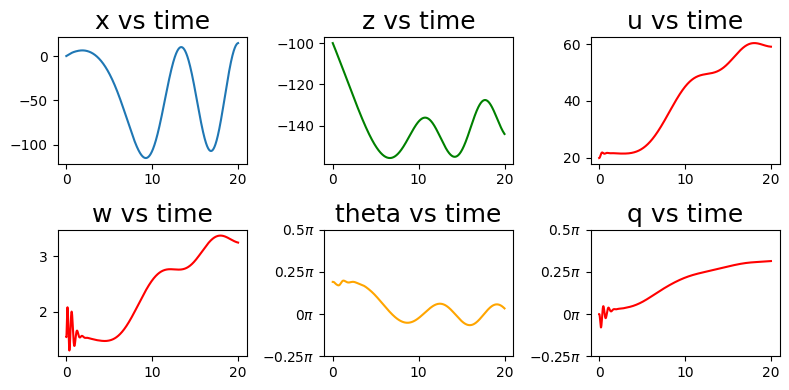

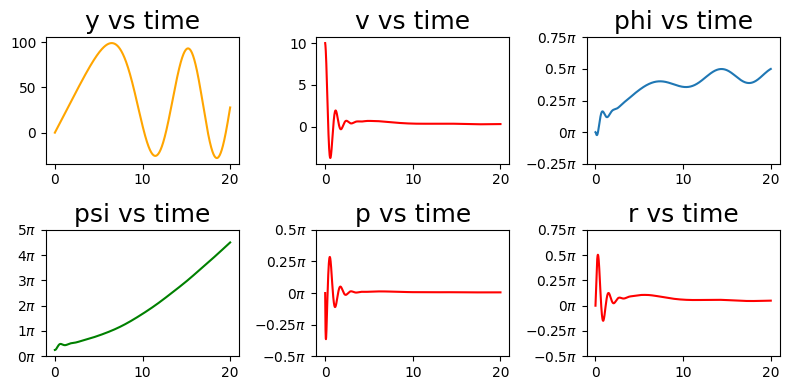

In [8]:
from airplane_plot import plot_airplane_data ,plot_airplane_long, plot_airplane_lat

plot_airplane_long(sol)
plot_airplane_lat(sol)

4 by 4 control

In [110]:
from airplane_3D_EOM_Linear import continuous_linearization, A_matrix_evalation

state_eq = np.array([[x_init], [y_init], [z_init], [u_init], [v_init], [w_init], 
                     [phi_init], [theta_init], [psi_init], [p_init], [q_init], [r_init]])

input_eq = np.array([[Thrust_init], [elevator_init],[aileron_init],[rudder_init]])

A_long4, B_long4, A_long6, B_long6, A_lat5, B_lat5, A_lat6, B_lat6 = continuous_linearization(state_eq.squeeze(), input_eq.squeeze())


u_max = 50
v_max = 50
w_max = 50
phi_max = np.pi
theta_max = np.pi
psi_max = np.pi
p_max = np.pi
q_max = np.pi
r_max = np.pi

u_weight = 0.1
w_weight = 0.1
q_weight = 0.000001
theta_weight = 10000.799999



Q_long = np.array([[u_weight/u_max**2, 0, 0, 0],
                  [0, w_weight/w_max**2, 0, 0],
                  [0, 0, q_weight/q_max**2, 0],
                  [0, 0, 0, theta_weight/theta_max**2]])

v_weight = 100
p_weight = 0.025
r_weight = 0.025
phi_weight = 0.05
psi_weight = 100

Q_lat = np.array([[v_weight/v_max**2, 0, 0, 0, 0],
                  [0, p_weight/p_max**2, 0, 0, 0],
                  [0, 0, r_weight/r_max**2, 0, 0],
                  [0, 0, 0, phi_weight/phi_max**2, 0],
                  [0, 0, 0, 0, psi_weight/psi_max**2]])

throttle_max = 100
elevator_max = np.pi
aileron_max = np.pi
rudder_max = np.pi

throttle_weight = 0.75
elevator_weight = 0.25
R_long = np.array([[throttle_weight/throttle_max**2, 0],
                  [0, elevator_weight/elevator_max**2]])

aileron_weight = 0.50
rudder_weight = 0.50
R_lat = np.array([[aileron_weight/aileron_max**2, 0],
                  [0, rudder_weight/rudder_max**2]])

K_long, S, e = control.lqr(A_long4, B_long4, Q_long, R_long)
print(K_long)
K_lat, S, e = control.lqr(A_lat5, B_lat5, Q_lat, R_lat)
print(K_lat)


[[ 5.26273339e-01 -2.76208899e-02  1.16839076e-02  1.24613125e+00]
 [-1.02476487e-02  1.36317878e-01 -3.95308388e+00 -2.00009138e+02]]
[[  0.70994547   0.18965701  -0.20072966   1.314845     5.92218554]
 [  0.33634171   0.0313531   -1.12847632  -0.21961789 -12.84241871]]


number of nonpositive real parts of long open eig: 2
number of nonpositive real parts of long closed eig: 4
number of nonpositive real parts of lat open eig: 4
number of nonpositive real parts of lat closed eig: 5


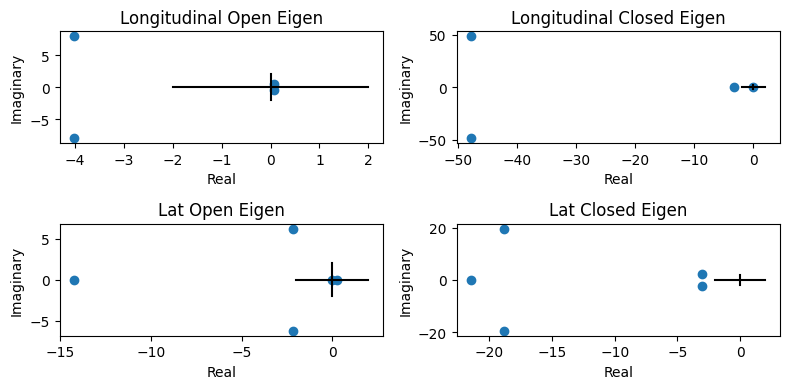

In [111]:
A_long_closed = A_long4 - B_long4 @ K_long
A_lat_closed = A_lat5 - B_lat5 @ K_lat

long_open_eig, _ = A_matrix_evalation(A_long4, dt)
long_closed_eig, _ = A_matrix_evalation(A_long_closed, dt)
lat_open_eig, _ = A_matrix_evalation(A_lat5, dt)
lat_closed_eig, _ = A_matrix_evalation(A_lat_closed, dt)

x = [ele.real for ele in long_open_eig]
y = [ele.imag for ele in long_open_eig]
real_positive = [ele for ele in x if ele <= 0]

print(f"number of nonpositive real parts of long open eig: {len(real_positive)}")

plt.figure(figsize=(8,4))
plt.subplot(2,2,1)
plt.title("Longitudinal Open Eigen")
plt.scatter(x, y) 
plt.ylabel('Imaginary') 
plt.xlabel('Real') 
plt.plot(np.arange(-2,3,1), np.zeros(5), 'k')
plt.plot(np.zeros(5), np.arange(-2,3,1), 'k')

###

x = [ele.real for ele in long_closed_eig]
y = [ele.imag for ele in long_closed_eig]
real_positive = [ele for ele in x if ele <= 0]

print(f"number of nonpositive real parts of long closed eig: {len(real_positive)}")

plt.subplot(2,2,2)
plt.title("Longitudinal Closed Eigen")
plt.scatter(x, y) 
plt.ylabel('Imaginary') 
plt.xlabel('Real') 
plt.plot(np.arange(-2,3,1), np.zeros(5), 'k')
plt.plot(np.zeros(5), np.arange(-2,3,1), 'k')

####
x = [ele.real for ele in lat_open_eig]
y = [ele.imag for ele in lat_open_eig]
real_positive = [ele for ele in x if ele <= 0]

print(f"number of nonpositive real parts of lat open eig: {len(real_positive)}")

plt.subplot(2,2,3)
plt.title("Lat Open Eigen")
plt.scatter(x, y) 
plt.ylabel('Imaginary') 
plt.xlabel('Real') 
plt.plot(np.arange(-2,3,1), np.zeros(5), 'k')
plt.plot(np.zeros(5), np.arange(-2,3,1), 'k')

###

x = [ele.real for ele in lat_closed_eig]
y = [ele.imag for ele in lat_closed_eig]
real_positive = [ele for ele in x if ele <= 0]

print(f"number of nonpositive real parts of lat closed eig: {len(real_positive)}")

plt.subplot(2,2,4)
plt.title("Lat Closed Eigen")
plt.scatter(x, y) 
plt.ylabel('Imaginary') 
plt.xlabel('Real') 
plt.plot(np.arange(-2,3,1), np.zeros(5), 'k')
plt.plot(np.zeros(5), np.arange(-2,3,1), 'k')

plt.tight_layout()
plt.show() 

In [112]:
z_init = -100
psi_init = 0#np.pi/4

Thrust_disturbance = 0
elevator_disturbance = 0
aileron_disturbance = 0
rudder_disturbance = 0

x_disturbance = 0
y_disturbance = 0
z_disturbance = 0
u_disturbance = u_init/10
v_disturbance = 10
w_disturbance = w_init/10
phi_disturbance = np.pi/8
theta_disturbance = np.pi/16
psi_disturbance = 0
p_disturbance = 0#np.pi/2
q_disturbance = np.pi/2
r_disturbance = 0#np.pi/2

# -np.pi/16 to aileon

input_init = np.array([[Thrust_init +Thrust_disturbance], [elevator_init + elevator_disturbance],[aileron_init+aileron_disturbance],[rudder_init+rudder_disturbance]])
state_init = np.array([[x_init + x_disturbance], [y_init + y_disturbance], [z_init + z_disturbance], 
                       [u_init + u_disturbance], [v_init + v_disturbance], [w_init + w_disturbance],
                       [phi_init + phi_disturbance], [theta_init + theta_disturbance], [psi_init + psi_disturbance], 
                       [p_init + p_disturbance], [q_init + q_disturbance], [r_init + r_disturbance]])

state_des = np.array([[x_init +244.95], [y_init +244.95], [z_init -200], 
                       [u_init ], [v_init ], [w_init ],
                       [phi_init ], [theta_init ], [psi_init ], 
                       [p_init ], [q_init ], [r_init ]])


from airplane_3D_EOM import simulate_airplane
duration = 18
dt = 0.01
sol_closed, state_des, t_list_des = simulate_airplane(state_init.squeeze(), state_des.squeeze(), input_init.squeeze(), K_long, K_lat, duration, dt)

In [113]:
np.save("sol_closed.npy", sol_closed.y)

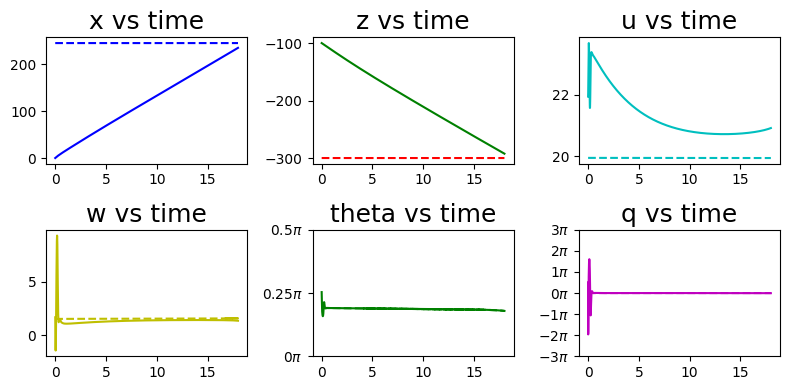

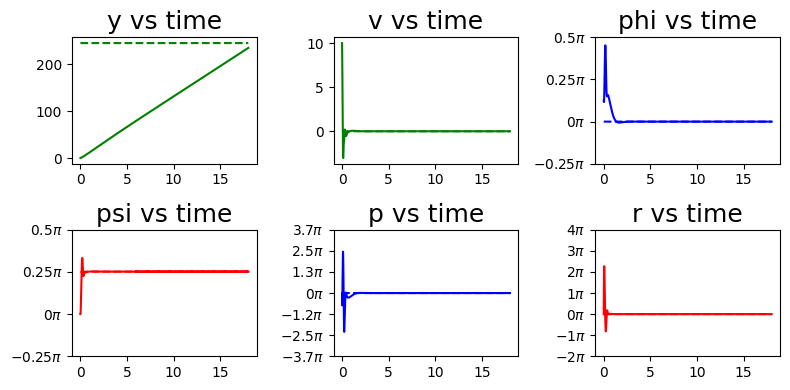

In [114]:
from airplane_plot import plot_airplane_data ,plot_airplane_long, plot_airplane_lat

plot_airplane_long(sol_closed, state_des, t_list_des)
plot_airplane_lat(sol_closed, state_des, t_list_des)

6 by 6

In [30]:
from airplane_3D_EOM_Linear import continuous_linearization, A_matrix_evalation

state_eq = np.array([[x_init], [y_init], [z_init], [u_init], [v_init], [w_init], 
                     [phi_init], [theta_init], [psi_init], [p_init], [q_init], [r_init]])

input_eq = np.array([[Thrust_init], [elevator_init],[aileron_init],[rudder_init]])

A_long4, B_long4, A_long6, B_long6, A_lat5, B_lat5, A_lat6, B_lat6 = continuous_linearization(state_eq.squeeze(), input_eq.squeeze())

x_max = 500
y_max = 500
z_max = 500
u_max = 50
v_max = 50
w_max = 50
phi_max = np.pi
theta_max = np.pi
psi_max = np.pi
p_max = np.pi
q_max = np.pi
r_max = np.pi

u_weight = 0.1
w_weight = 0.1
q_weight = 0.1
theta_weight = 0.1
x_weight = 0.3
z_weight = 0.3



Q_long = np.array([[u_weight/u_max**2, 0, 0, 0, 0, 0],
                  [0, w_weight/w_max**2, 0, 0, 0, 0],
                  [0, 0, q_weight/q_max**2, 0, 0, 0],
                  [0, 0, 0, theta_weight/theta_max**2, 0, 0],
                  [0, 0, 0, 0, x_weight/x_max**2, 0],
                  [0, 0, 0, 0, 0, z_weight/z_max**2]])

v_weight = 0.1
p_weight = 0.05
r_weight = 0.05
phi_weight = 0.3
psi_weight = 0.3
y_weight = 0.2

Q_lat = np.array([[v_weight/v_max**2, 0, 0, 0, 0, 0],
                  [0, p_weight/p_max**2, 0, 0, 0, 0],
                  [0, 0, r_weight/r_max**2, 0, 0, 0],
                  [0, 0, 0, phi_weight/phi_max**2, 0, 0],
                  [0, 0, 0, 0, psi_weight/psi_max**2, 0],
                  [0, 0, 0, 0, 0, y_weight/y_max**2]])


# u_weight = 0.5
# w_weight = 0.5
# q_weight = 0.001
# theta_weight = 0.01
# x_weight = 1000000
# z_weight = 1000000



# Q_long = np.array([[u_weight/u_max**2, 0, 0, 0, 0, 0],
#                   [0, w_weight/w_max**2, 0, 0, 0, 0],
#                   [0, 0, q_weight/q_max**2, 0, 0, 0],
#                   [0, 0, 0, theta_weight/theta_max**2, 0, 0],
#                   [0, 0, 0, 0, x_weight/x_max**2, 0],
#                   [0, 0, 0, 0, 0, z_weight/z_max**2]])


# v_weight = 100
# p_weight = 0.001
# r_weight = 0.001
# phi_weight = 10
# psi_weight = 10
# y_weight = 10000000

# Q_lat = np.array([[v_weight/v_max**2, 0, 0, 0, 0, 0],
#                   [0, p_weight/p_max**2, 0, 0, 0, 0],
#                   [0, 0, r_weight/r_max**2, 0, 0, 0],
#                   [0, 0, 0, phi_weight/phi_max**2, 0, 0],
#                   [0, 0, 0, 0, psi_weight/psi_max**2, 0],
#                   [0, 0, 0, 0, 0, y_weight/y_max**2]])


throttle_max = 100
elevator_max = np.pi
aileron_max = np.pi
rudder_max = np.pi

throttle_weight = 0.75
elevator_weight = 0.25
R_long_weight = 0.0001
R_long = R_long_weight * np.array([[throttle_weight/throttle_max**2, 0],
                                    [0, elevator_weight/elevator_max**2]])

aileron_weight = 0.50
rudder_weight = 0.50
R_lat_weight = 0.0001
R_lat = R_lat_weight * np.array([[aileron_weight/aileron_max**2, 0],
                                [0, rudder_weight/rudder_max**2]])

K_long6, S, e = control.lqr(A_long6, B_long6, Q_long, R_long)
print(K_long6)
K_lat6, S, e = control.lqr(A_lat6, B_lat6, Q_lat, R_lat)
print(K_lat6)




[[ 7.46033811e+01 -3.88772411e+00 -3.80257091e-01  1.00374050e+01
   9.73971212e+00 -8.07081209e+00]
 [ 7.90721328e-02 -1.47573728e-01 -6.31015782e+01 -8.20555813e+01
   4.39165015e-01  5.29976509e-01]]
[[  1.49878828  31.40474624  -0.97995576  75.81942118  -2.17574403
    0.24224802]
 [ -0.28234753  -1.15199942 -31.67445631 -25.65207647 -89.42161257
   -0.31500725]]


number of nonpositive real parts of long open eig: 4
number of nonpositive real parts of long closed eig: 6
number of nonpositive real parts of lat open eig: 5
number of nonpositive real parts of lat closed eig: 6


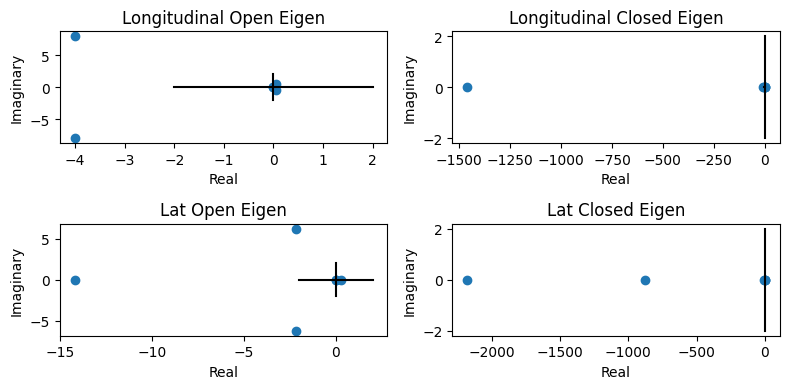

In [31]:
A_long_closed = A_long6 - B_long6 @ K_long6
A_lat_closed = A_lat6 - B_lat6 @ K_lat6

long_open_eig, _ = A_matrix_evalation(A_long6, dt)
long_closed_eig, _ = A_matrix_evalation(A_long_closed, dt)
lat_open_eig, _ = A_matrix_evalation(A_lat6, dt)
lat_closed_eig, _ = A_matrix_evalation(A_lat_closed, dt)

x = [ele.real for ele in long_open_eig]
y = [ele.imag for ele in long_open_eig]
real_positive = [ele for ele in x if ele <= 0]

print(f"number of nonpositive real parts of long open eig: {len(real_positive)}")

plt.figure(figsize=(8,4))
plt.subplot(2,2,1)
plt.title("Longitudinal Open Eigen")
plt.scatter(x, y) 
plt.ylabel('Imaginary') 
plt.xlabel('Real') 
plt.plot(np.arange(-2,3,1), np.zeros(5), 'k')
plt.plot(np.zeros(5), np.arange(-2,3,1), 'k')

###

x = [ele.real for ele in long_closed_eig]
y = [ele.imag for ele in long_closed_eig]
real_positive = [ele for ele in x if ele <= 0]

print(f"number of nonpositive real parts of long closed eig: {len(real_positive)}")

plt.subplot(2,2,2)
plt.title("Longitudinal Closed Eigen")
plt.scatter(x, y) 
plt.ylabel('Imaginary') 
plt.xlabel('Real') 
plt.plot(np.arange(-2,3,1), np.zeros(5), 'k')
plt.plot(np.zeros(5), np.arange(-2,3,1), 'k')

####
x = [ele.real for ele in lat_open_eig]
y = [ele.imag for ele in lat_open_eig]
real_positive = [ele for ele in x if ele <= 0]

print(f"number of nonpositive real parts of lat open eig: {len(real_positive)}")

plt.subplot(2,2,3)
plt.title("Lat Open Eigen")
plt.scatter(x, y) 
plt.ylabel('Imaginary') 
plt.xlabel('Real') 
plt.plot(np.arange(-2,3,1), np.zeros(5), 'k')
plt.plot(np.zeros(5), np.arange(-2,3,1), 'k')

###

x = [ele.real for ele in lat_closed_eig]
y = [ele.imag for ele in lat_closed_eig]
real_positive = [ele for ele in x if ele <= 0]

print(f"number of nonpositive real parts of lat closed eig: {len(real_positive)}")

plt.subplot(2,2,4)
plt.title("Lat Closed Eigen")
plt.scatter(x, y) 
plt.ylabel('Imaginary') 
plt.xlabel('Real') 
plt.plot(np.arange(-2,3,1), np.zeros(5), 'k')
plt.plot(np.zeros(5), np.arange(-2,3,1), 'k')

plt.tight_layout()
plt.show() 

In [32]:
z_init = -100
psi_init = np.pi/4

Thrust_disturbance = 0
elevator_disturbance = 0
aileron_disturbance = 0
rudder_disturbance = 0

x_disturbance = 0
y_disturbance = 0
z_disturbance = 0
u_disturbance = 0#u_init/10
v_disturbance = 0#10
w_disturbance = 0#w_init/10
phi_disturbance = 0#np.pi/8
theta_disturbance = 0#np.pi/16
psi_disturbance = 0
p_disturbance = 0#np.pi/2
q_disturbance = 0#np.pi/2
r_disturbance = 0#np.pi/2

# -np.pi/16 to aileon

input_init = np.array([[Thrust_init +Thrust_disturbance], [elevator_init + elevator_disturbance],[aileron_init+aileron_disturbance],[rudder_init+rudder_disturbance]])
state_init = np.array([[x_init + x_disturbance], [y_init + y_disturbance], [z_init + z_disturbance], 
                       [u_init + u_disturbance], [v_init + v_disturbance], [w_init + w_disturbance],
                       [phi_init + phi_disturbance], [theta_init + theta_disturbance], [psi_init + psi_disturbance], 
                       [p_init + p_disturbance], [q_init + q_disturbance], [r_init + r_disturbance]])

state_des = np.array([[x_init +244.95], [y_init +244.95], [z_init -200], 
                       [u_init ], [v_init ], [w_init ],
                       [phi_init ], [theta_init ], [psi_init ], 
                       [p_init ], [q_init ], [r_init ]])


from airplane_3D_EOM import simulate_airplane6
duration = 20
dt = 0.01
sol_closed6 = simulate_airplane6(state_init.squeeze(), state_des.squeeze(), input_init.squeeze(), K_long6, K_lat6, duration, dt)

In [29]:
np.save("sol_closed6.npy", sol_closed6.y)

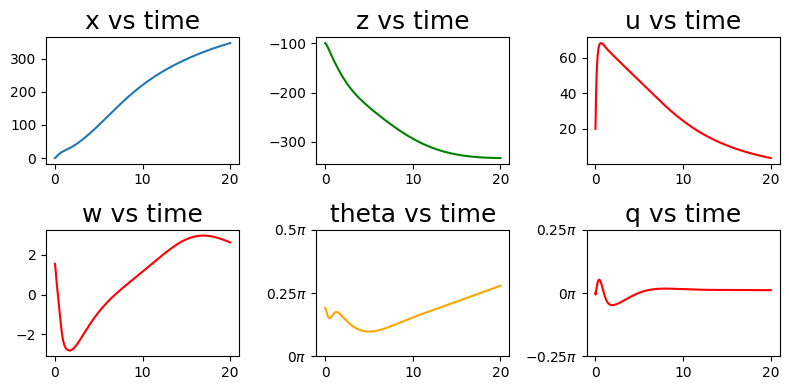

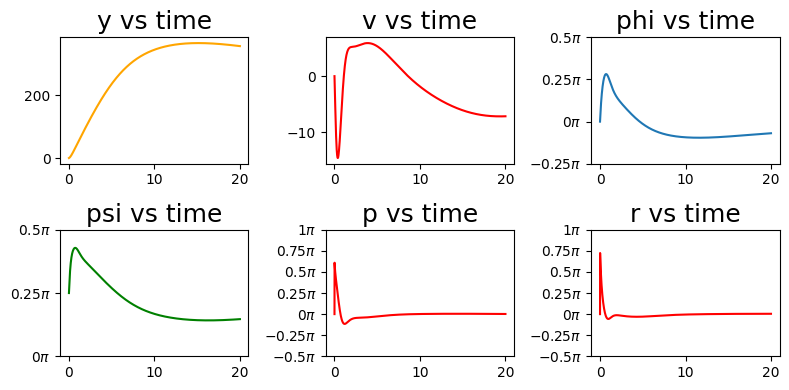

In [33]:
from airplane_plot import plot_airplane_data ,plot_airplane_long, plot_airplane_lat

plot_airplane_long(sol_closed6)
plot_airplane_lat(sol_closed6)

In [16]:
from airplane_3D_EOM_Linear import discrete_simulation

state_eq = np.array([[x_init], [y_init], [z_init], [u_init], [v_init], [w_init], 
                     [phi_init], [theta_init], [psi_init], [p_init], [q_init], [r_init]])

input_eq = np.array([[Thrust_init], [elevator_init],[aileron_init],[rudder_init]])


results = discrete_simulation(state_eq, input_eq, state_init, input_init, dt, duration)


In [17]:
print(results[:,0])
print(results[:,1])

[   0.            0.         -100.           19.94056541   10.
    1.54073071    0.39269908    0.60071171    0.78539816    1.57079633
    0.            1.57079633]
[   0.12247449    0.22247449 -100.1          19.94056541   19.69012391
    1.54073071    0.81186894    0.60071171    0.80443965    2.75890475
    0.            3.2136862 ]


In [18]:
np.save("sol_linear.npy", results)

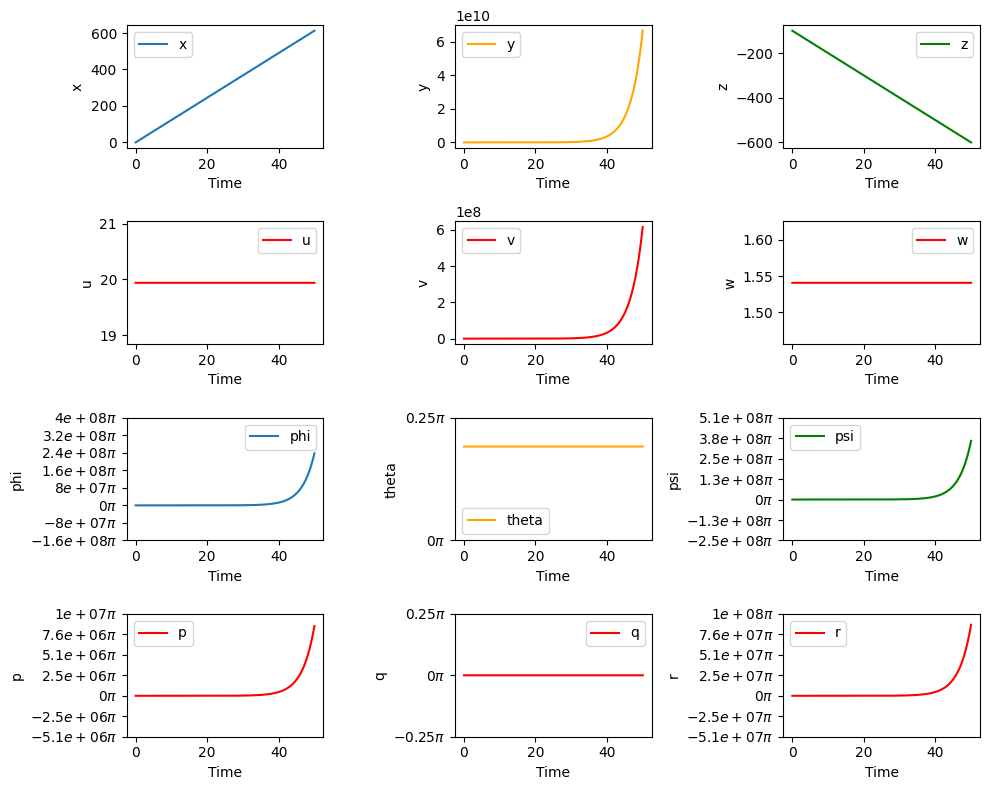

In [19]:
class solutions:
    pass

results_list = results.tolist()


sol_discrete = solutions()
sol_discrete.t = np.arange(0,duration+dt/2,dt).tolist()
sol_discrete.y = [None] * 12
sol_discrete.y[0] = results_list[0]
sol_discrete.y[1] = results_list[1]
sol_discrete.y[2] = results_list[2]
sol_discrete.y[3] = results_list[3]
sol_discrete.y[4] = results_list[4]
sol_discrete.y[5] = results_list[5]
sol_discrete.y[6] = results_list[6]
sol_discrete.y[7] = results_list[7]
sol_discrete.y[8] = results_list[8]
sol_discrete.y[9] = results_list[9]
sol_discrete.y[10] = results_list[10]
sol_discrete.y[11] = results_list[11]




from airplane_plot import plot_airplane_data

plot_airplane_data(sol_discrete)

In [20]:
# from airplane_3D_EOM_Linear import discrete_simulation2


# state_init = np.array([[x_init], [y_init], [z_init], [u_init], [v_init], [w_init],
#                    [phi_init], [theta_init], [psi_init], [p_init], [q_init], [r_init]])
# input_init = np.array([[Thrust], [elevator],[aileron],[rudder]])
# input_new = np.array([[Thrust+Thrust_disturbance], [elevator+elevator_disturbance],[aileron+aileron_disturbance],[rudder+rudder_disturbance]])

# results2 = discrete_simulation2(state_init, input_init, input_new, dt, duration)

In [21]:
# class solutions:
#     pass

# results_list2 = results2.tolist()


# sol_discrete2 = solutions()
# sol_discrete2.t = np.arange(0,duration+dt/2,dt).tolist()
# sol_discrete2.y = [None] * 12
# sol_discrete2.y[0] = results_list2[0]
# sol_discrete2.y[1] = results_list2[1]
# sol_discrete2.y[2] = results_list2[2]
# sol_discrete2.y[3] = results_list2[3]
# sol_discrete2.y[4] = results_list2[4]
# sol_discrete2.y[5] = results_list2[5]
# sol_discrete2.y[6] = results_list2[6]
# sol_discrete2.y[7] = results_list2[7]
# sol_discrete2.y[8] = results_list2[8]
# sol_discrete2.y[9] = results_list2[9]
# sol_discrete2.y[10] = results_list2[10]
# sol_discrete2.y[11] = results_list2[11]




# from airplane_plot import plot_airplane_data

# plot_airplane_data(sol_discrete2)

In [22]:
# class solutions:
#     pass


# error = solutions()
# error.t = np.arange(0,duration+dt/2,dt).tolist()
# error.y = [None] * 12
# error.y[0] = sol_discrete.y[0] - sol.y[0]
# error.y[1] = sol_discrete.y[1] - sol.y[1]
# error.y[2] = sol_discrete.y[2] - sol.y[2]
# error.y[3] = sol_discrete.y[3] - sol.y[3]
# error.y[4] = sol_discrete.y[4] - sol.y[4]
# error.y[5] = sol_discrete.y[5] - sol.y[5]
# error.y[6] = sol_discrete.y[6] - sol.y[6]
# error.y[7] = sol_discrete.y[7] - sol.y[7]
# error.y[8] = sol_discrete.y[8] - sol.y[8]
# error.y[9] = sol_discrete.y[9] - sol.y[9]
# error.y[10] =sol_discrete.y[10] - sol.y[10]
# error.y[11] = sol_discrete.y[11] - sol.y[11]

# from airplane_plot import plot_airplane_data

# plot_airplane_data(error)

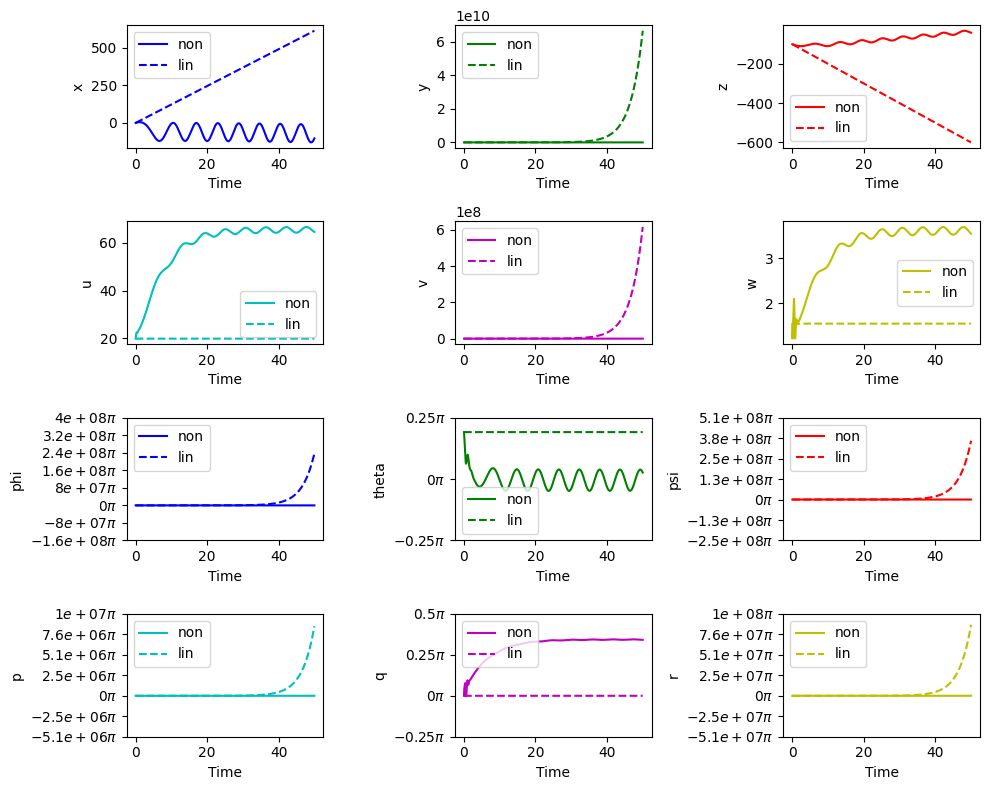

In [23]:
from airplane_plot import plot_airplane_compare_data

plot_airplane_compare_data(sol, sol_discrete)

In [24]:
# from airplane_plot import plot_airplane_compare_data

# plot_airplane_compare_data(sol, sol_discrete2)